In [1]:
import cv2
import numpy as np
from scipy.interpolate import interp1d
import argparse
from skimage import io
import matplotlib.pyplot as plt

In [2]:
s_path = './example/source.png'

In [3]:
r_path = './example/ref.png'

### Histogram Matching

##### Color Transfering by adjusting the histogram to match

In [4]:
def est_cdf(X):
    bins = np.arange(257)
    y = np.histogram(X, bins, density=True)
    cdf_hist = np.cumsum(y[0])
    x_range = y[1][:256]
    P = interp1d(x_range, cdf_hist)
    return P

In [5]:
def transfer(from_im, to_im):
    # Get the cdf's for each array, as well as the inverse cdf for the from_im
    F = est_cdf(to_im)
    G = est_cdf(from_im)
    G_inv = np.interp(F.y, G.y, G.x, left=0.0, right=1.0)

    # Figure out how to map olf values to new values
    mapping = {}
    x_range = np.arange(256)
    for n, i in enumerate(x_range):
        val = F(i)
        xj = G_inv[n]
        xj = round(xj)
        mapping[i] = xj

    # Apply the mapping
    v_map = np.vectorize(lambda x: mapping[x])
    result = v_map(to_im)
    return result 

In [6]:
def transfer_using_colorspace(source, reference, strength = 1.0):
    from_im_cvt = cv2.cvtColor(reference, cv2.COLOR_BGR2LAB)
    to_im_cvt = cv2.cvtColor(source, cv2.COLOR_BGR2LAB)
    result = to_im_cvt.copy()
    # Only apply histogram transfer in a and b channal
    for i in [1,2]:
        result[:,:,i] = transfer(from_im_cvt[:,:,i], to_im_cvt[:,:,i])
    return cv2.cvtColor(result, cv2.COLOR_LAB2BGR)*strength + source * (1 - strength)

#### Read images

In [7]:
source = io.imread(s_path)
reference = io.imread(r_path)

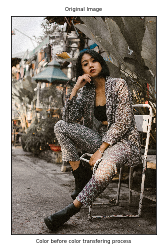

In [8]:
plt.imshow(source)
plt.title('Original Image', fontsize=5)
plt.xlabel('Color before color transfering process', fontsize=5)
plt.xticks([])
plt.yticks([])
plt.savefig("./result/figure_1_source_image.png", dpi=300,bbox_inches='tight')

In [9]:
plt.close()

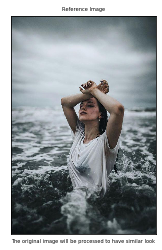

In [10]:
plt.imshow(reference)
plt.title('Reference Image', fontsize=5)
plt.xlabel('The original image will be processed to have similar look', fontsize=5)
plt.xticks([])
plt.yticks([])
plt.savefig("./result/figure_2_reference_image.png", dpi=300,bbox_inches='tight')

In [11]:
plt.close()

In [12]:
source = cv2.cvtColor(source, cv2.COLOR_RGB2BGR)
reference = cv2.cvtColor(reference, cv2.COLOR_RGB2BGR)

In [13]:
strength = 0.8

#### Convert to CIELab

In [14]:
source_im_cvt = cv2.cvtColor(source, cv2.COLOR_BGR2LAB)
reference_im_cvt = cv2.cvtColor(reference, cv2.COLOR_BGR2LAB)

In [15]:
result = source_im_cvt.copy()

### Alpha channal

In [16]:
alpha_source_im = source_im_cvt[:,:,1]
alpha_reference_im = reference_im_cvt[:,:,1]

#### Find source CDF

In [17]:
bins = np.arange(257)
hist, hist_bin = np.histogram(alpha_source_im, bins, density=True)

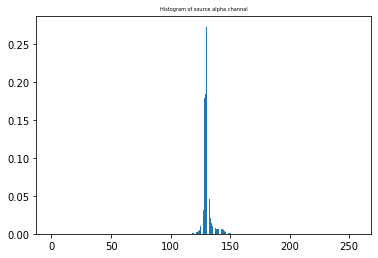

In [18]:
center = (hist_bin[:-1] + hist_bin[1:]) / 2
width = 0.7 * (hist_bin[1] - hist_bin[0])
plt.title('Histogram of source alpha channal', fontsize=5)
plt.bar(center, hist, align='center', width=width)
plt.savefig("./result/figure_3_source_image_histogram_alpha_.png", dpi=300)

In [19]:
plt.close()

In [20]:
cdf_hist = np.cumsum(hist)
x_range = hist_bin[:256]
alpha_s_cdf = interp1d(x_range, cdf_hist)

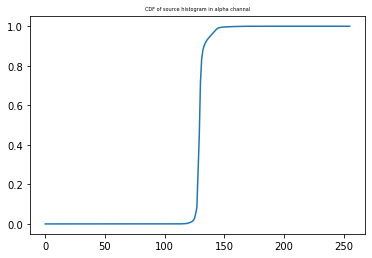

In [21]:
plt.title('CDF of source histogram in alpha channal', fontsize=5)
plt.plot(alpha_s_cdf.x,alpha_s_cdf.y)
plt.savefig("./result/figure_4_source_image_cdf_alpha_.png", dpi=300)

In [22]:
plt.close()

#### Find reference CDF

In [23]:
bins = np.arange(257)
hist, hist_bin = np.histogram(alpha_reference_im, bins, density=True)

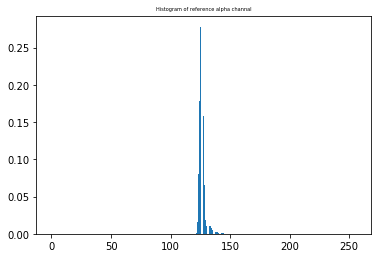

In [24]:
center = (hist_bin[:-1] + hist_bin[1:]) / 2
width = 0.7 * (hist_bin[1] - hist_bin[0])
plt.title('Histogram of reference alpha channal', fontsize=5)
plt.bar(center, hist, align='center', width=width)
plt.savefig("./result/figure_5_reference_image_histogram_alpha_.png", dpi=300)

In [25]:
plt.close()

In [26]:
cdf_hist = np.cumsum(hist)
x_range = hist_bin[:256]
alpha_r_cdf = interp1d(x_range, cdf_hist)

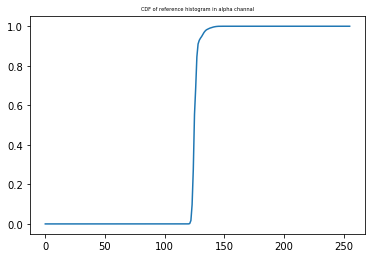

In [27]:
plt.title('CDF of reference histogram in alpha channal', fontsize=5)
plt.plot(alpha_r_cdf.x,alpha_r_cdf.y)
plt.savefig("./result/figure_6_reference_image_cdf_alpha_.png", dpi=300)

In [28]:
plt.close()

In [29]:
alpha_r_cdf_inverse = np.interp(alpha_s_cdf.y, alpha_r_cdf.y, alpha_r_cdf.x, left=0.0, right=1.0)

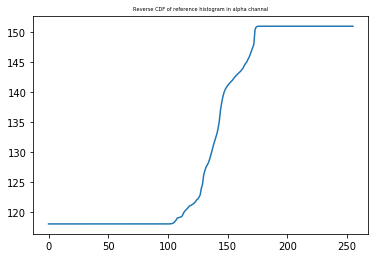

In [30]:
x_range = hist_bin[:256]
plt.title('Reverse CDF of reference histogram in alpha channal', fontsize=5)
plt.plot(x_range,alpha_r_cdf_inverse)
plt.savefig("./result/figure_7_reference_image_reversed_cdf_alpha_.png", dpi=300)

In [31]:
plt.close()

#### Map old value to new value

In [32]:
mapping = {}
x_range = np.arange(256) 

In [33]:
for n, i in enumerate(x_range):
    xj = alpha_r_cdf_inverse[n]
    xj = round(xj)
    mapping[i] = xj

In [34]:
v_map = np.vectorize(lambda x: mapping[x])

In [35]:
result[:,:,1] = v_map(source)

ValueError: could not broadcast input array from shape (7500,5000,3) into shape (7500,5000)

### Beta channal

In [ ]:
beta_source_im = source_im_cvt[:,:,2]
beta_reference_im = reference_im_cvt[:,:,2]

#### Find source CDF

In [ ]:
bins = np.arange(257)
hist, hist_bin = np.histogram(beta_source_im, bins, density=True)

In [ ]:
center = (hist_bin[:-1] + hist_bin[1:]) / 2
width = 0.7 * (hist_bin[1] - hist_bin[0])
plt.title('Histogram of source beta channal', fontsize=5)
plt.bar(center, hist, align='center', width=width)
plt.savefig("./result/figure_8_source_image_histogram_beta_.png", dpi=300)

In [ ]:
plt.close()

In [ ]:
cdf_hist = np.cumsum(hist)
x_range = hist_bin[:256]
beta_s_cdf = interp1d(x_range, cdf_hist)

In [ ]:
plt.title('CDF of source histogram in beta channal', fontsize=5)
plt.plot(beta_s_cdf.x,beta_s_cdf.y)
plt.savefig("./result/figure_9_source_image_cdf_beta_.png", dpi=300)

#### Find reference CDF

In [ ]:
bins = np.arange(257)
hist, hist_bin = np.histogram(beta_reference_im, bins, density=True)

In [ ]:
center = (hist_bin[:-1] + hist_bin[1:]) / 2
width = 0.7 * (hist_bin[1] - hist_bin[0])
plt.title('Histogram of reference beta channal', fontsize=5)
plt.bar(center, hist, align='center', width=width)
plt.savefig("./result/figure_10_reference_image_histogram_beta_.png", dpi=300)

In [ ]:
plt.close()

In [ ]:
cdf_hist = np.cumsum(hist)
x_range = hist_bin[:256]
beta_r_cdf = interp1d(x_range, cdf_hist)

In [ ]:
plt.title('CDF of reference histogram in alpha channal', fontsize=5)
plt.plot(beta_r_cdf.x,beta_r_cdf.y)
plt.savefig("./result/figure_11_reference_image_cdf_beta_.png", dpi=300)

In [ ]:
plt.close()

In [ ]:
beta_r_cdf_inverse = np.interp(beta_s_cdf.y, beta_r_cdf.y, beta_r_cdf.x, left=0.0, right=1.0)

In [ ]:
x_range = hist_bin[:256]
plt.title('Reverse CDF of reference histogram in beta channal', fontsize=5)
plt.plot(x_range,beta_r_cdf_inverse)
plt.savefig("./result/figure_12_reference_image_reversed_cdf_beta_.png", dpi=300)

In [ ]:
plt.close()

#### Map old value to new value

In [ ]:
mapping = {}
x_range = np.arange(256) 

In [ ]:
for n, i in enumerate(x_range):
    xj = beta_r_cdf_inverse[n]
    xj = round(xj)
    mapping[i] = xj

In [ ]:
v_map = np.vectorize(lambda x: mapping[x])

In [ ]:
result[:,:,2] = v_map(source)

#### Transfer value

In [ ]:
result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR) * strength + source * (1 - strength)

In [ ]:
cv2.imwrite('./result/output.jpg', result)